In [1]:
import os
import shap
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from hyperopt import hp
import lightgbm as lgbm
from sklearn.svm import SVC
from hyperopt.pyll import scope
from utils.dependencies import *
from sklearn.model_selection import (
    cross_validate, 
    cross_val_score, 
    KFold, 
    train_test_split)
from sklearn.ensemble import (
    RandomForestClassifier, 
    AdaBoostClassifier, 
    ExtraTreesClassifier)
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from lifelines.utils import survival_table_from_events


%pylab inline
%matplotlib inline
warnings.filterwarnings("ignore")
pylab.rcParams['figure.figsize'] = (14, 9)

Populating the interactive namespace from numpy and matplotlib


In [2]:
DATA_INTER_PATH = os.path.join('..', 'data', 'interim')
DATA_PROCE_PATH = os.path.join('..', 'data', 'processed')
IMG_PATH = os.path.join('..','reports', 'figures')
DATA_INTER_NAME = 'general.csv'
DATA_INTER_NAME_2 = 'general_2.csv'
DATA_PROCE_NAME = 'processed.csv'

MODEL_PATH = os.path.join('..', 'models')
MODEL_NAME = 'model.pkl'

SEED = 55

## Survival Analysis

In [3]:
def survival_probability(value):

    array = np.asarray(survtable["at_risk"].index)
    idx = (np.abs(array - value)).argmin()
    
    temp = survtable.reset_index()
    proba = temp[temp['event_at'] == array[idx]].at_risk.values[0]*100
    
    return print("A probabilidade de sobrevivência do cliente após", array[idx], "dias é", round(proba, 2),"%") 

In [4]:
df = pd.read_csv(os.path.join(DATA_PROCE_PATH, DATA_PROCE_NAME))
df.head(1)

,customer_code,group_code,segment_code,total_price,item_total_price,discount,last_purchase_date,qnt_days,is_churn
0,0,0,0,74215.11,84322.67,1,2018-06-08 00:00:00+00:00,54,0.0


In [5]:
time = df["qnt_days"]
event = df["is_churn"]

kmf = KaplanMeierFitter()
kmf.fit(time, event_observed=event)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 818 total observations, 737 right-censored observations>

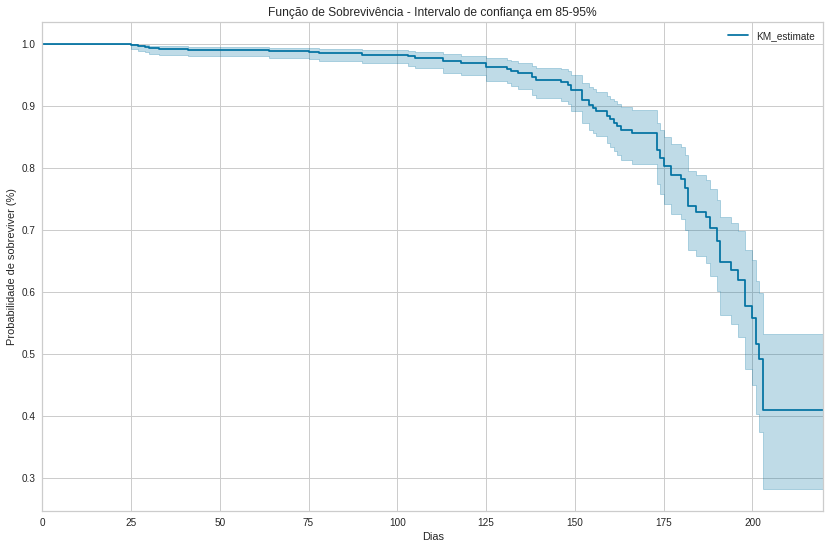

In [6]:
kmf.plot()
plt.xlim(0, 220)
plt.title('Função de Sobrevivência - Intervalo de confiança em 85-95%');
plt.ylabel('Probabilidade de sobreviver (%)')
plt.xlabel('Dias')
plt.savefig(os.path.join(IMG_PATH,'km-general.png'), format='png')
plt.show()

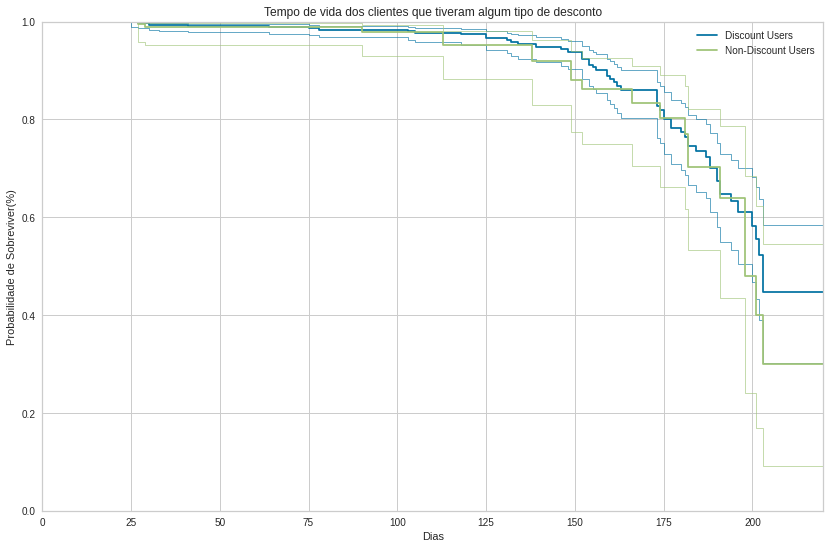

In [7]:
ax = plt.subplot(111)

discount = (df["discount"] == 1)
kmf.fit(time[discount], event_observed=event[discount], label="Discount Users")
kmf.plot(ax=ax, ci_force_lines=True)
kmf.fit(time[~discount], event_observed=event[~discount], label="Non-Discount Users")
kmf.plot(ax=ax, ci_force_lines=True)
plt.ylim(0,1)
plt.xlim(0, 220)
plt.title("Tempo de vida dos clientes que tiveram algum tipo de desconto")
plt.ylabel('Probabilidade de Sobreviver(%)')
plt.xlabel('Dias')
plt.savefig(os.path.join(IMG_PATH,'km-discount.png'), format='png')
plt.show()

In [8]:
groups = sorted(df.group_code.unique())
segments = sorted(df.segment_code.unique())

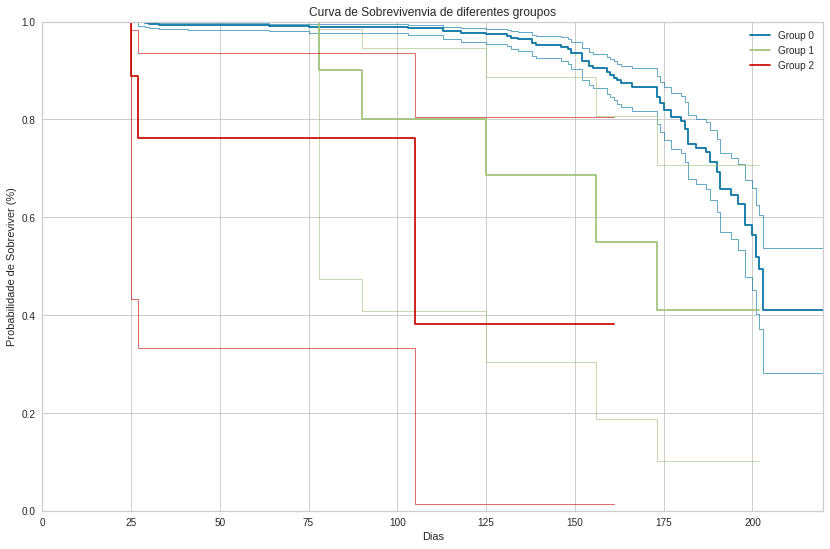

In [9]:
ax = plt.subplot(111)

group_0 = (df["group_code"] == groups[0])
group_1 = (df["group_code"] == groups[1])
group_2 = (df["group_code"] == groups[2])

kmf.fit(time[group_0], event_observed=event[group_0], label="Group 0")
kmf.plot(ax=ax, ci_force_lines=True)

kmf.fit(time[group_1], event_observed=event[group_1], label="Group 1")
kmf.plot(ax=ax, ci_force_lines=True)

kmf.fit(time[group_2], event_observed=event[group_2], label="Group 2")
kmf.plot(ax=ax, ci_force_lines=True)

plt.xlim(0, 220)
plt.ylim(0,1)
plt.title("Curva de Sobrevivenvia de diferentes groupos")
plt.ylabel('Probabilidade de Sobreviver (%)')
plt.xlabel('Dias')
plt.savefig(os.path.join(IMG_PATH,'km-group.png'), format='png')
plt.show()

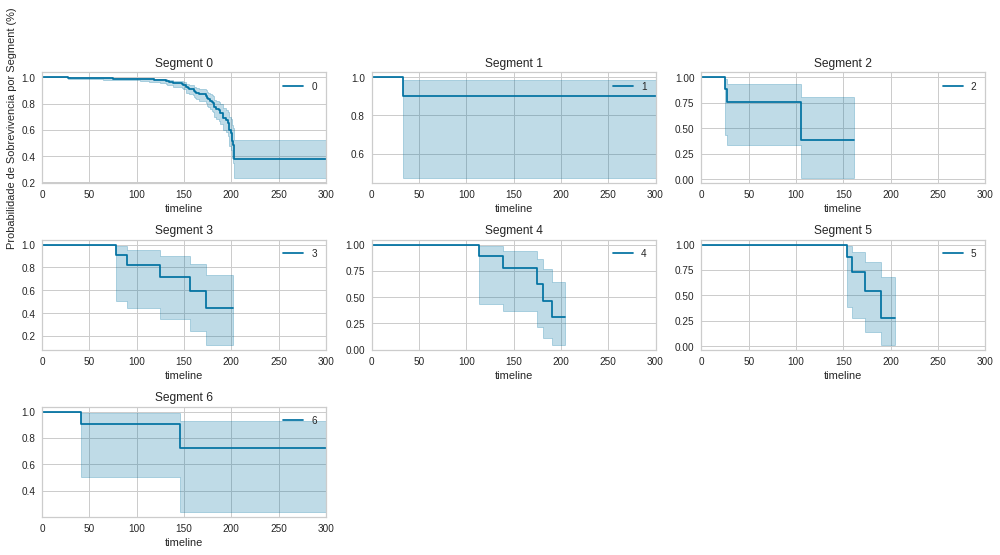

In [10]:
for i, segment_type in enumerate(segments):
    ax = plt.subplot(4,3,i+1)
    ix = df['segment_code'] == segment_type
    kmf.fit(time[ix], event[ix], label=segment_type )
    kmf.plot(ax=ax, legend=True)
    plt.title(f'Segment {segment_type}')
    plt.xlim(0,300)
    if i==0:
        plt.ylabel('Probabilidade de Sobrevivencia por Segment (%)')
        
plt.savefig(os.path.join(IMG_PATH,'km-segment.png'), format='png')
plt.tight_layout()

In [11]:
time = df["qnt_days"]
event = df["is_churn"]

lifetable = survival_table_from_events(time, event)

In [12]:
survivaltable = lifetable.at_risk/np.amax(lifetable.entrance)

In [13]:
survtable = pd.DataFrame(survivaltable)

In [14]:
survival_probability(50)

A probabilidade de sobrevivência do cliente após 50.0 dias é 79.71 %


## Modeling

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818 entries, 0 to 817
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_code       818 non-null    int64  
 1   group_code          818 non-null    int64  
 2   segment_code        818 non-null    int64  
 3   total_price         818 non-null    float64
 4   item_total_price    818 non-null    float64
 5   discount            818 non-null    int64  
 6   last_purchase_date  818 non-null    object 
 7   qnt_days            818 non-null    int64  
 8   is_churn            818 non-null    float64
dtypes: float64(3), int64(5), object(1)
memory usage: 57.6+ KB


In [16]:
X = df.drop(['customer_code', 'last_purchase_date', 'is_churn'], axis=1)
y = df['is_churn']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,
                                                    random_state=SEED,
                                                    stratify=y)

In [17]:
models = [
          ('DecisionTree', DecisionTreeClassifier(random_state=SEED)),
          ('RandomForest', RandomForestClassifier(random_state=SEED)),
          ('ExtraTree', ExtraTreesClassifier(random_state=SEED)),
          ('Adaboost', AdaBoostClassifier(random_state=SEED)),
          ('XGBoost', xgb.XGBClassifier(random_state=SEED, verbosity=0)),
          ('LightGBM', lgbm.LGBMClassifier(random_state=SEED)),
          ('LogisticRegression', LogisticRegression(random_state=SEED, solver='saga')),
          ('SVC', SVC(random_state=SEED))
          ]

In [18]:
original = pd.DataFrame()

for name, model in tqdm(models):

    kfold = KFold(n_splits=3, random_state=SEED, shuffle=True)
    
    score = cross_validate(
        model, 
        X_train, 
        y_train, 
        cv=kfold, 
        scoring=[
            'precision_weighted',
            'recall_weighted',
            'f1_weighted'
        ], 
        return_train_score=True
    )        
    
    additional = pd.DataFrame(
        {
            'precision_train':np.mean(score['train_precision_weighted']),
            'precision_test':np.mean(score['test_precision_weighted']),
            'recall_train':np.mean(score['train_recall_weighted']),
            'recall_test':np.mean(score['test_recall_weighted']),
            'f1_train':np.mean(score['train_f1_weighted']),
            'f1_test':np.mean(score['test_f1_weighted'])
        }, 
        index=[name]
    )

    new = pd.concat([original, additional], axis=0)
    original = new

original

  0%|          | 0/8 [00:00<?, ?it/s]

,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test
DecisionTree,1.000000,0.889201,1.000000,0.893387,1.000000,0.891106
RandomForest,1.000000,0.911517,1.000000,0.919574,1.000000,0.913273
ExtraTree,1.000000,0.918153,1.000000,0.924828,1.000000,0.917650
Adaboost,0.966698,0.911813,0.967657,0.919574,0.966008,0.913864
XGBoost,0.998250,0.899774,0.998250,0.907348,0.998250,0.901341
LightGBM,1.000000,0.908210,1.000000,0.914329,1.000000,0.909637
LogisticRegression,0.810692,0.810878,0.900354,0.900367,0.853159,0.853226
SVC,0.912381,0.810592,0.908221,0.896877,0.872160,0.851475


  0%|          | 0/8 [00:00<?, ?it/s]

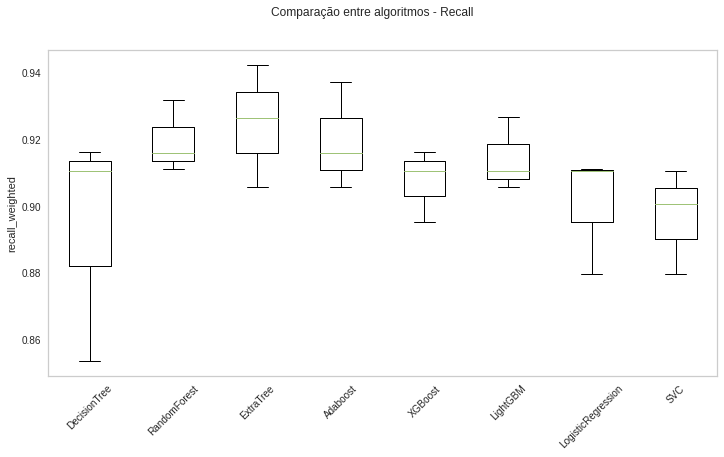

<Figure size 1008x648 with 0 Axes>

In [19]:
results = []
names = []

for name, model in tqdm(models):
    cv_results = cross_val_score(
        model, 
        X_train, 
        y_train, 
        cv=kfold, 
        scoring=('recall_weighted')
    )
    results.append(cv_results)
    names.append(name)

fig = plt.figure(figsize=(12,6))
fig.suptitle('Comparação entre algoritmos - Recall')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylabel('recall_weighted')
plt.xticks(rotation=45)
plt.grid(b=False)
plt.show()

plt.savefig(os.path.join(IMG_PATH,'models-score.png'), format='png')

In [20]:
param_hyperopt= {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 20, 1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 5, 100, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 5, 35, 1)),
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 20.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 20.0),
    'feature_fraction': hp.uniform('feature_fraction', 0.3, 1.0)
}

In [21]:
best_param, model = hyperopt(param_hyperopt, X_train, y_train, X_test, y_test, num_eval=100)

[LightGBM] [Warning] feature_fraction is set=0.8503844764813029, colsample_bytree=0.6921119913621526 will be ignored. Current value: feature_fraction=0.8503844764813029
[LightGBM] [Warning] feature_fraction is set=0.8503844764813029, colsample_bytree=0.6921119913621526 will be ignored. Current value: feature_fraction=0.8503844764813029
[LightGBM] [Warning] feature_fraction is set=0.8503844764813029, colsample_bytree=0.6921119913621526 will be ignored. Current value: feature_fraction=0.8503844764813029
[LightGBM] [Warning] feature_fraction is set=0.8503844764813029, colsample_bytree=0.6921119913621526 will be ignored. Current value: feature_fraction=0.8503844764813029
[LightGBM] [Warning] feature_fraction is set=0.8503844764813029, colsample_bytree=0.6921119913621526 will be ignored. Current value: feature_fraction=0.8503844764813029
[LightGBM] [Warning] feature_fraction is set=0.3409410301359157, colsample_bytree=0.7022779271309514 will be ignored. Current value: feature_fraction=0.340

[LightGBM] [Warning] feature_fraction is set=0.5338250530827793, colsample_bytree=0.9654799173420916 will be ignored. Current value: feature_fraction=0.5338250530827793
[LightGBM] [Warning] feature_fraction is set=0.5338250530827793, colsample_bytree=0.9654799173420916 will be ignored. Current value: feature_fraction=0.5338250530827793
[LightGBM] [Warning] feature_fraction is set=0.813404448393648, colsample_bytree=0.9675483082075919 will be ignored. Current value: feature_fraction=0.813404448393648
[LightGBM] [Warning] feature_fraction is set=0.813404448393648, colsample_bytree=0.9675483082075919 will be ignored. Current value: feature_fraction=0.813404448393648
[LightGBM] [Warning] feature_fraction is set=0.813404448393648, colsample_bytree=0.9675483082075919 will be ignored. Current value: feature_fraction=0.813404448393648
[LightGBM] [Warning] feature_fraction is set=0.813404448393648, colsample_bytree=0.9675483082075919 will be ignored. Current value: feature_fraction=0.8134044483

[LightGBM] [Warning] feature_fraction is set=0.840598713676624, colsample_bytree=0.6904318788096493 will be ignored. Current value: feature_fraction=0.840598713676624
[LightGBM] [Warning] feature_fraction is set=0.840598713676624, colsample_bytree=0.6904318788096493 will be ignored. Current value: feature_fraction=0.840598713676624
[LightGBM] [Warning] feature_fraction is set=0.840598713676624, colsample_bytree=0.6904318788096493 will be ignored. Current value: feature_fraction=0.840598713676624
[LightGBM] [Warning] feature_fraction is set=0.6248282616990908, colsample_bytree=0.6533701362892059 will be ignored. Current value: feature_fraction=0.6248282616990908
[LightGBM] [Warning] feature_fraction is set=0.6248282616990908, colsample_bytree=0.6533701362892059 will be ignored. Current value: feature_fraction=0.6248282616990908
[LightGBM] [Warning] feature_fraction is set=0.6248282616990908, colsample_bytree=0.6533701362892059 will be ignored. Current value: feature_fraction=0.624828261

[LightGBM] [Warning] feature_fraction is set=0.5060164126194217, colsample_bytree=0.6732389453507475 will be ignored. Current value: feature_fraction=0.5060164126194217
[LightGBM] [Warning] feature_fraction is set=0.5060164126194217, colsample_bytree=0.6732389453507475 will be ignored. Current value: feature_fraction=0.5060164126194217
[LightGBM] [Warning] feature_fraction is set=0.5060164126194217, colsample_bytree=0.6732389453507475 will be ignored. Current value: feature_fraction=0.5060164126194217
[LightGBM] [Warning] feature_fraction is set=0.5060164126194217, colsample_bytree=0.6732389453507475 will be ignored. Current value: feature_fraction=0.5060164126194217
[LightGBM] [Warning] feature_fraction is set=0.5060164126194217, colsample_bytree=0.6732389453507475 will be ignored. Current value: feature_fraction=0.5060164126194217
[LightGBM] [Warning] feature_fraction is set=0.5130453573392133, colsample_bytree=0.6789657620212067 will be ignored. Current value: feature_fraction=0.513

[LightGBM] [Warning] feature_fraction is set=0.3441757777687719, colsample_bytree=0.8543405788690079 will be ignored. Current value: feature_fraction=0.3441757777687719
[LightGBM] [Warning] feature_fraction is set=0.3441757777687719, colsample_bytree=0.8543405788690079 will be ignored. Current value: feature_fraction=0.3441757777687719
[LightGBM] [Warning] feature_fraction is set=0.9013910093461749, colsample_bytree=0.9226071693634624 will be ignored. Current value: feature_fraction=0.9013910093461749
[LightGBM] [Warning] feature_fraction is set=0.9013910093461749, colsample_bytree=0.9226071693634624 will be ignored. Current value: feature_fraction=0.9013910093461749
[LightGBM] [Warning] feature_fraction is set=0.9013910093461749, colsample_bytree=0.9226071693634624 will be ignored. Current value: feature_fraction=0.9013910093461749
[LightGBM] [Warning] feature_fraction is set=0.9013910093461749, colsample_bytree=0.9226071693634624 will be ignored. Current value: feature_fraction=0.901

[LightGBM] [Warning] feature_fraction is set=0.7517781622642004, colsample_bytree=0.738890279031194 will be ignored. Current value: feature_fraction=0.7517781622642004
[LightGBM] [Warning] feature_fraction is set=0.7517781622642004, colsample_bytree=0.738890279031194 will be ignored. Current value: feature_fraction=0.7517781622642004
[LightGBM] [Warning] feature_fraction is set=0.7517781622642004, colsample_bytree=0.738890279031194 will be ignored. Current value: feature_fraction=0.7517781622642004
[LightGBM] [Warning] feature_fraction is set=0.7517781622642004, colsample_bytree=0.738890279031194 will be ignored. Current value: feature_fraction=0.7517781622642004
[LightGBM] [Warning] feature_fraction is set=0.3978711615875034, colsample_bytree=0.7601193375543138 will be ignored. Current value: feature_fraction=0.3978711615875034
[LightGBM] [Warning] feature_fraction is set=0.3978711615875034, colsample_bytree=0.7601193375543138 will be ignored. Current value: feature_fraction=0.3978711

[LightGBM] [Warning] feature_fraction is set=0.5988553582432501, colsample_bytree=0.7496583934901644 will be ignored. Current value: feature_fraction=0.5988553582432501
[LightGBM] [Warning] feature_fraction is set=0.9669773952548126, colsample_bytree=0.8663904724599918 will be ignored. Current value: feature_fraction=0.9669773952548126
[LightGBM] [Warning] feature_fraction is set=0.9669773952548126, colsample_bytree=0.8663904724599918 will be ignored. Current value: feature_fraction=0.9669773952548126
[LightGBM] [Warning] feature_fraction is set=0.9669773952548126, colsample_bytree=0.8663904724599918 will be ignored. Current value: feature_fraction=0.9669773952548126
[LightGBM] [Warning] feature_fraction is set=0.9669773952548126, colsample_bytree=0.8663904724599918 will be ignored. Current value: feature_fraction=0.9669773952548126
[LightGBM] [Warning] feature_fraction is set=0.9669773952548126, colsample_bytree=0.8663904724599918 will be ignored. Current value: feature_fraction=0.966

[LightGBM] [Warning] feature_fraction is set=0.4624921451965468, colsample_bytree=0.7309685904908461 will be ignored. Current value: feature_fraction=0.4624921451965468
[LightGBM] [Warning] feature_fraction is set=0.4624921451965468, colsample_bytree=0.7309685904908461 will be ignored. Current value: feature_fraction=0.4624921451965468
[LightGBM] [Warning] feature_fraction is set=0.4624921451965468, colsample_bytree=0.7309685904908461 will be ignored. Current value: feature_fraction=0.4624921451965468
[LightGBM] [Warning] feature_fraction is set=0.43576774002504276, colsample_bytree=0.711893386886055 will be ignored. Current value: feature_fraction=0.43576774002504276
[LightGBM] [Warning] feature_fraction is set=0.43576774002504276, colsample_bytree=0.711893386886055 will be ignored. Current value: feature_fraction=0.43576774002504276
[LightGBM] [Warning] feature_fraction is set=0.43576774002504276, colsample_bytree=0.711893386886055 will be ignored. Current value: feature_fraction=0.4

[LightGBM] [Warning] feature_fraction is set=0.6782303284615467, colsample_bytree=0.7489483926132795 will be ignored. Current value: feature_fraction=0.6782303284615467
[LightGBM] [Warning] feature_fraction is set=0.6782303284615467, colsample_bytree=0.7489483926132795 will be ignored. Current value: feature_fraction=0.6782303284615467
[LightGBM] [Warning] feature_fraction is set=0.6782303284615467, colsample_bytree=0.7489483926132795 will be ignored. Current value: feature_fraction=0.6782303284615467
[LightGBM] [Warning] feature_fraction is set=0.6782303284615467, colsample_bytree=0.7489483926132795 will be ignored. Current value: feature_fraction=0.6782303284615467
[LightGBM] [Warning] feature_fraction is set=0.6782303284615467, colsample_bytree=0.7489483926132795 will be ignored. Current value: feature_fraction=0.6782303284615467
[LightGBM] [Warning] feature_fraction is set=0.7307086864173656, colsample_bytree=0.770960770332138 will be ignored. Current value: feature_fraction=0.7307

[LightGBM] [Warning] feature_fraction is set=0.42701921686037253, colsample_bytree=0.6939569942596294 will be ignored. Current value: feature_fraction=0.42701921686037253
[LightGBM] [Warning] feature_fraction is set=0.42701921686037253, colsample_bytree=0.6939569942596294 will be ignored. Current value: feature_fraction=0.42701921686037253
[LightGBM] [Warning] feature_fraction is set=0.514391469127508, colsample_bytree=0.6343503869526584 will be ignored. Current value: feature_fraction=0.514391469127508
[LightGBM] [Warning] feature_fraction is set=0.514391469127508, colsample_bytree=0.6343503869526584 will be ignored. Current value: feature_fraction=0.514391469127508
[LightGBM] [Warning] feature_fraction is set=0.514391469127508, colsample_bytree=0.6343503869526584 will be ignored. Current value: feature_fraction=0.514391469127508
[LightGBM] [Warning] feature_fraction is set=0.514391469127508, colsample_bytree=0.6343503869526584 will be ignored. Current value: feature_fraction=0.514391

[LightGBM] [Warning] feature_fraction is set=0.3323944745578531, colsample_bytree=0.6418816467252109 will be ignored. Current value: feature_fraction=0.3323944745578531
[LightGBM] [Warning] feature_fraction is set=0.3323944745578531, colsample_bytree=0.6418816467252109 will be ignored. Current value: feature_fraction=0.3323944745578531
[LightGBM] [Warning] feature_fraction is set=0.3323944745578531, colsample_bytree=0.6418816467252109 will be ignored. Current value: feature_fraction=0.3323944745578531
[LightGBM] [Warning] feature_fraction is set=0.3323944745578531, colsample_bytree=0.6418816467252109 will be ignored. Current value: feature_fraction=0.3323944745578531
[LightGBM] [Warning] feature_fraction is set=0.31088156684883184, colsample_bytree=0.7431551715846159 will be ignored. Current value: feature_fraction=0.31088156684883184
[LightGBM] [Warning] feature_fraction is set=0.31088156684883184, colsample_bytree=0.7431551715846159 will be ignored. Current value: feature_fraction=0.

**Results**

Score best parameters:  0.8090909090909092

Best parameters:  {'boosting_type': 0, 'colsample_by_tree': 0.7903468954908037, 'feature_fraction': 0.49780231586959944, 'learning_rate': 0.8865683202570385, 'max_depth': 11.0, 'n_estimators': 88.0, 'num_leaves': 22.0, 'reg_alpha': 13.308122471390172, 'reg_lambda': 4.424831836611828}

Test Score:  0.6219512195121951

Time elapsed:  22.89320945739746

Parameter combinations evaluated:  100

In [22]:
model

LGBMClassifier(colsample_bytree=0.7903468954908037,
               feature_fraction=0.49780231586959944,
               learning_rate=0.8865683202570385, max_depth=11, n_estimators=88,
               num_leaves=22, random_state=55, reg_alpha=13.308122471390172,
               reg_lambda=4.424831836611828)

In [23]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

[LightGBM] [Warning] feature_fraction is set=0.49780231586959944, colsample_bytree=0.7903468954908037 will be ignored. Current value: feature_fraction=0.49780231586959944
              precision    recall  f1-score   support

         0.0       0.96      0.60      0.74       222
         1.0       0.18      0.79      0.29        24

    accuracy                           0.62       246
   macro avg       0.57      0.70      0.52       246
weighted avg       0.89      0.62      0.70       246



In [28]:
y_test.value_counts()

0.0    222
1.0     24
Name: is_churn, dtype: int64

[LightGBM] [Warning] feature_fraction is set=0.49780231586959944, colsample_bytree=0.7903468954908037 will be ignored. Current value: feature_fraction=0.49780231586959944


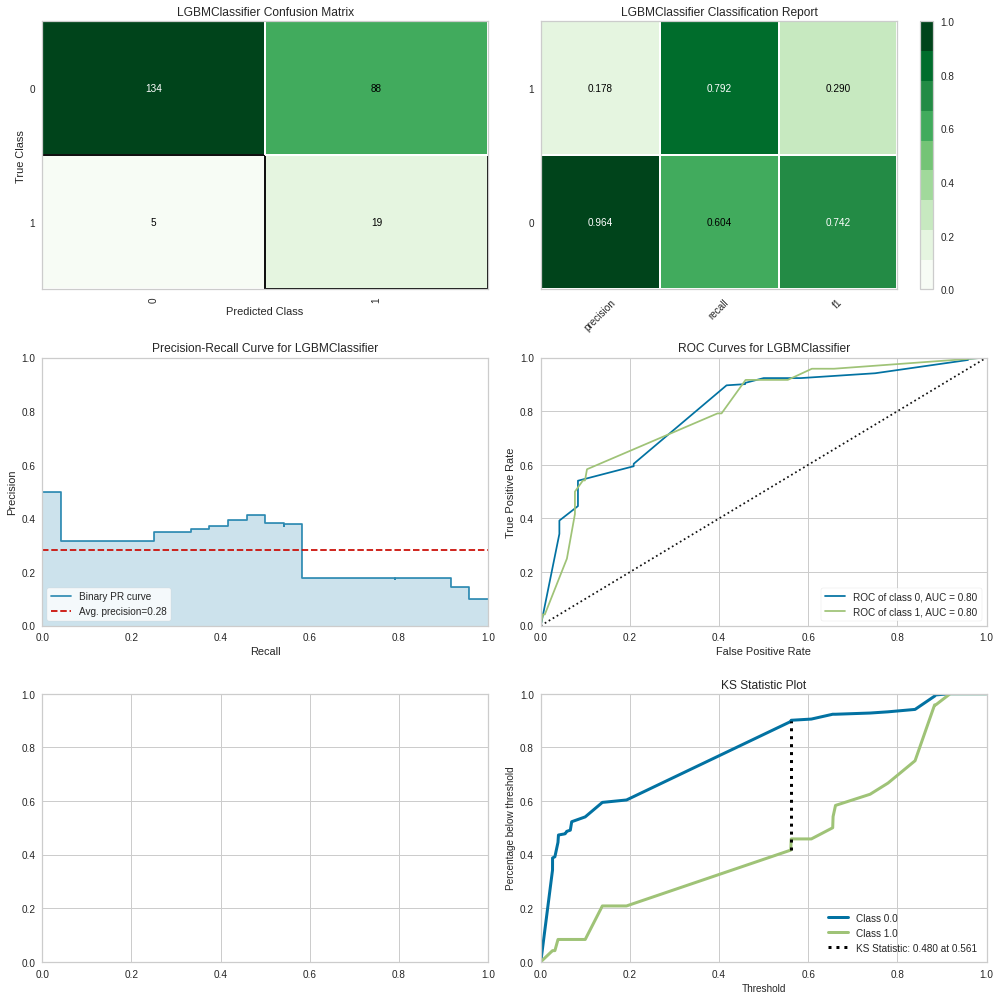

<Figure size 1008x648 with 0 Axes>

In [29]:
viz_performance(X_train, X_test, y_train, y_test, model, ['0', '1'], figsize=(14,14))
plt.savefig(os.path.join(IMG_PATH,'lgbm-metrics.png'), format='png')

In [25]:
pickle.dump(model, open(os.path.join(MODEL_PATH, MODEL_NAME), 'wb'))

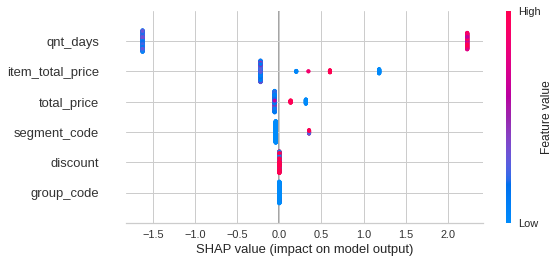

<Figure size 1008x648 with 0 Axes>

In [26]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test)
plt.savefig(os.path.join(IMG_PATH,'shap-values.png'), format='png')

## Considerações

1. Há um decaimento quase que exponencial depois do dia 150;
2. Depois do dia número 200, a probabilidade de sobrevivência de um cliente é de aproximadamente de 50%. Em outras palavras: depois de 200 dias, métade dos clientes dariam **churn**;
3. Clientes com e sem desconto tem comportamento semalhantes quanto a sobrevivencia;
4. O grupo 2 mostra maior probabilidade em um intervalo de tempo pequeno de dar churn;
5. Métrica escolhida para modelagem foi **Recall**, pois os Falsos Negativos tem um impacto maior no negócio;
6. Modelo conseguiu performar bem mesmo com a classe **desbalanceada**;
7. O modelo junto da análise de sobrevivência conseguiríamos criar regras junto ao négocio e antecipar possíveis churn.

Obs: A análise realizada para grupos e segmentos possuem um intervalo de confiança alto devido a faltas de dados para esses grupos.

### Próximo passos:
1. Adicionar mais dados aos grupos;
2. Criar modelo de **churn** para cada grupo de cliente;
3. Balancear nossa classe;
4. Adicionar mais features para o modelo;